In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#### Q1. Downloading the data - Read the data for January. How many records are there?

In [2]:
df_jan = pd.read_parquet("./data/fhv_tripdata_2021-01.parquet")
print("Number of records :", df_jan.shape[0])

Number of records : 1154112


#### Q2. Computing duration - What's the average trip duration in January?

In [3]:
df_jan['duration'] = df_jan['dropOff_datetime'] - df_jan['pickup_datetime']
df_jan.duration = df_jan.duration.apply(lambda x: x.total_seconds()/60)

In [4]:
print("Average trip duration in January :", df_jan.duration.mean())

Average trip duration in January : 19.1672240937939


#### Q3. Missing values - What's the fractions of missing values for the pickup location ID? (Or the fraction of "-1"s after filling NAs)

In [5]:
df_org = df_jan.shape[0]
df_jan = df_jan[(df_jan.duration>=1) & (df_jan.duration<=60)]
row_dropped = df_org - df_jan.shape[0]
print("Number of records dropped :",row_dropped)

Number of records dropped : 44286


In [6]:
tot_rec = df_jan.PUlocationID.shape[0]
nan_rec = df_jan.PUlocationID.isna().sum()
missing_value_frac = (nan_rec/tot_rec)*100
print("Fractions of missing values for the pickup location ID :", missing_value_frac)

Fractions of missing values for the pickup location ID : 83.52732770722618


In [7]:
df_jan['PUlocationID'] = df_jan.PUlocationID.fillna(-1)
df_jan['DOlocationID'] = df_jan.DOlocationID.fillna(-1)
df_jan

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,-1.0,-1.0,NaN,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,-1.0,-1.0,NaN,B00009,17.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,-1.0,72.0,NaN,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,-1.0,61.0,NaN,B00037,15.216667
5,B00037,2021-01-01 00:59:02,2021-01-01 01:08:05,-1.0,71.0,NaN,B00037,9.050000
...,...,...,...,...,...,...,...,...
1154107,B03266,2021-01-31 23:43:03,2021-01-31 23:51:48,7.0,7.0,NaN,B03266,8.750000
1154108,B03284,2021-01-31 23:50:27,2021-02-01 00:48:03,44.0,91.0,NaN,,57.600000
1154109,B03285,2021-01-31 23:13:46,2021-01-31 23:29:58,171.0,171.0,NaN,B03285,16.200000
1154110,B03285,2021-01-31 23:58:03,2021-02-01 00:17:29,15.0,15.0,NaN,B03285,19.433333


#### Q4. One-hot encoding

In [8]:
categorical = ['PUlocationID', 'DOlocationID']
label = 'duration'
df_jan[categorical] = df_jan[categorical].astype(str)
train_dict = df_jan[categorical].to_dict(orient='records')


In [9]:
#df_jan['PU_DO'] = df_jan.PUlocationID + '_' + df_jan.DOlocationID
dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)
y_train = df_jan[label].values

In [10]:
X_train, y_train

(<1109826x525 sparse matrix of type '<class 'numpy.float64'>'
 	with 2219652 stored elements in Compressed Sparse Row format>,
 array([17.        , 17.        ,  8.28333333, ..., 16.2       ,
        19.43333333, 36.        ]))

In [11]:
X_train.shape, y_train.shape

((1109826, 525), (1109826,))

#### Q5. Training a model - What's the RMSE on train?

In [12]:
#linear regression
regressor  = LinearRegression()
regressor.fit(X_train,y_train)

y_pred = regressor.predict(X_train)

In [13]:
y_pred, y_train

(array([23.05208486, 23.05208486, 14.10570259, ..., 16.61396091,
        11.13740006, 23.05208486]),
 array([17.        , 17.        ,  8.28333333, ..., 16.2       ,
        19.43333333, 36.        ]))

In [14]:
RMSE_train = mean_squared_error(y_train, y_pred, squared=False)
RMSE_train

10.5285191072072

##### Q6. Evaluating the model - Now let's apply this model to the validation dataset (Feb 2021)

In [15]:
# reading data
df_feb = pd.read_parquet("./data/fhv_tripdata_2021-02.parquet")
# computing duration
df_feb['duration'] = df_feb['dropOff_datetime'] - df_feb['pickup_datetime']
# setting up duration in mins
df_feb.duration = df_feb.duration.apply(lambda x: x.total_seconds()/60)
# conscidering dataset for 1<=duration.values<=60 - to negate outliers
df_feb = df_feb[(df_feb.duration>=1) & (df_feb.duration<=60)]

# replacing NaN with -1 for PU & DU location id
df_feb['PUlocationID'] = df_feb.PUlocationID.fillna(-1)
df_feb['DOlocationID'] = df_feb.DOlocationID.fillna(-1)

In [16]:
categorical = ['PUlocationID', 'DOlocationID']
label = 'duration'
# converting from int to str - for one hot encoding preparation
df_feb[categorical] = df_feb[categorical].astype(str)
test_dict = df_feb[categorical].to_dict(orient='records')


In [17]:
# one hot encoding
# dv --> defined earlier
# transform NOT fit_transform
X_test = dv.transform(test_dict)
y_test = df_feb[label].values

In [18]:
X_test, y_test

(<990113x525 sparse matrix of type '<class 'numpy.float64'>'
 	with 1980223 stored elements in Compressed Sparse Row format>,
 array([10.66666667, 14.56666667,  7.95      , ..., 25.38333333,
        18.05      , 16.        ]))

In [19]:
X_test.shape, y_test.shape

((990113, 525), (990113,))

In [20]:
#linear regression - result from previous model
y_feb_pred = regressor.predict(X_test)

In [21]:
y_feb_pred, y_test

(array([14.5398734 , 13.74043662, 15.5933284 , ..., 15.83489517,
        16.78316683, 19.65462163]),
 array([10.66666667, 14.56666667,  7.95      , ..., 25.38333333,
        18.05      , 16.        ]))

In [22]:
RMSE_test = mean_squared_error(y_test, y_feb_pred, squared=False)
print(RMSE_test)

11.014283163400654


/home/arunabha/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/arunabha/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


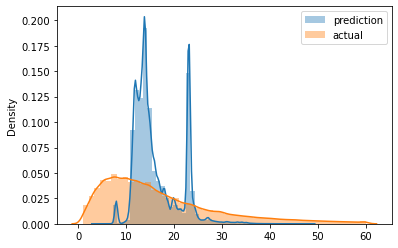

In [23]:
sns.distplot(y_feb_pred, label='prediction')
sns.distplot(y_test, label='actual')

plt.legend()